# 분석하는 과정
- 데이터 불러오기
- 모델의 일반화 성능을 위해 train set과  test set 분리
- train set을 기준으로 전처리 및 EDA
- train set


## 1.데이터 불러오기

In [133]:
#  # colab 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 한글폰트 사용을 위해 설치
# 아래 코드 실행하면 한글 폰트 설치할 필요 없음!
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [135]:
raw_data = pd.read_csv('/content/drive/MyDrive/비어플/dataset/Titanic-Dataset.csv')

In [136]:
data = raw_data.copy()

## 2.데이터 확인하기
-  PassengerId: 승객 ID (각 승객에 대한 고유 식별자)
-  Survived: 생존 여부 (0 = 사망, 1 = 생존)
-  Pclass: 티켓 클래스 (1 = 1등석, 2 = 2등석, 3 = 3등석)
-  Name: 승객 이름
-  Sex: 성별 (male, female)
-  Age: 나이
-  SibSp: 함께 탑승한 형제 또는 배우자 수
-  Parch: 함께 탑승한 부모 또는 자녀 수
-  Ticket: 티켓 번호
-  Fare: 운임 요금
-  Cabin: 객실 번호
-  Embarked: 탑승한 항구 (C = Cherbourg, Q = Queenstown, S = Southampton)


In [137]:
data.duplicated().sum()  # 중복된 행 없음

0

In [138]:
data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


우리의 목적은 survived를 예측하는 것인데 일반화에 도움이 되지 않는 Name, Passengerld, Ticket 는 제거한다

In [139]:
data = data.drop(columns=['PassengerId', 'Name','Ticket'])

X와 y를 나눈다

In [140]:
columns = data.columns
X = data.iloc[:,columns != 'Survived']
y = data.iloc[:,columns == 'Survived']

In [141]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, random_state = 1234, test_size=0.3)
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True) # y 비율이 같도록 분리

(Survived
 0           0.616372
 1           0.383628
 Name: proportion, dtype: float64,
 Survived
 0           0.615672
 1           0.384328
 Name: proportion, dtype: float64)

편의성을 위해 train과 test로 합치기

In [142]:
train = pd.concat([X_train,y_train],axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [143]:
# 데이터 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 623 entries, 477 to 403
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    623 non-null    int64  
 1   Sex       623 non-null    object 
 2   Age       493 non-null    float64
 3   SibSp     623 non-null    int64  
 4   Parch     623 non-null    int64  
 5   Fare      623 non-null    float64
 6   Cabin     142 non-null    object 
 7   Embarked  622 non-null    object 
 8   Survived  623 non-null    int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 48.7+ KB


## 3.결측치 살펴보기

In [144]:
# 결측치 확인
train.isna().sum()
# Cabin 대부분 결측치
# Age 대략 200개 결측치
# Embarked 1개 결측치

,0
Pclass,0
Sex,0
Age,130
SibSp,0
Parch,0
Fare,0
Cabin,481
Embarked,1
Survived,0


### 3.1 Age 결측치 채우기
동일한 특성을 가진 행들의 평균값으로 채우기

In [145]:
print(train['Age'].isna().sum()) # 원래 Age 결측치 수
group_mean = train.groupby(['Pclass','Sex'])['Age'].mean().reset_index() # 동일한 특성을 가진 행들의 Age평균 구하기
tmp = pd.merge(train.loc[train['Age'].isna(),['Pclass', 'Sex']], group_mean, on=['Pclass', 'Sex'], how='left') # Age가 결측치인 데이터에 Age평균을 결합하기
train.loc[train['Age'].isna(),'Age'] = tmp['Age'].values
print(train['Age'].isna().sum()) # Age 결측치수가 0임을 확인

130
0


### 3.2 Embarked 결측치 채우기
최반값으로 채우기

In [146]:
print(train['Embarked'].isna().sum())
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
print(train['Embarked'].isna().sum())

1
0


<ipython-input-146-8121e7e2f99c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)


### 3.3 Cabin 열은 결측치가 매우 많으므로 결측치 유무로 구분


In [147]:
train['Cabin'] = ~train['Cabin'].isna()

## 4.데이터 전처리

### 4.1 Age변수를 그룹화

In [148]:
age_bins = [0,7,18,40,60,100]
age_labels = ['어린이', '학생', '성인','중장년','노인']  # 신체적 특성을 기준으로 구분하였다
train['Age_group'] = pd.cut(train['Age'], bins=age_bins, labels=age_labels, right=False)

### 4.2 Family 파생변수 생성 <- Sibsp + Parch
Family 라는 파생변수를 만들고 Sibsp 와 Parch변수는 제거한다  
이미 Family변수 내에 정보를 포함하고 있으므로...

In [149]:
# 먼저 파생변수 만들기
train['Family'] = train['SibSp'] + train['Parch']

In [150]:
train = train.drop(['SibSp','Parch'],axis=1) # 변수 제거

## 5.범주형 변수 인코딩
- Age 변수는 순서가 존재하는 특성이라고 간주
- Sex는 원핫 인코딩
- Embarked도 원핫 인코딩
- Pclass는 순서형으로 간주하여 그대로 둠

In [151]:
train['Age_group'] = train['Age_group'].map({'어린이':0,'학생':1,'성인':2,'중장년':3,'노인':4}).astype(int) # Age_group을 순서형으로

In [152]:
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1}) # Sex를 원 핫 인코딩

In [153]:
train = pd.get_dummies(train, drop_first = True, columns = ['Embarked'])

In [154]:
X_train = train.drop('Survived',axis=1)
y_train = train['Survived']

## 6.test set 전처리하기(train과 동일하게)

### 6.1 결측치 처리

In [155]:
test.isna().sum()

,0
Pclass,0
Sex,0
Age,47
SibSp,0
Parch,0
Fare,0
Cabin,206
Embarked,1
Survived,0


#### Age 변수 결측치 처리

In [156]:
print(test['Age'].isna().sum()) # 원래 Age 결측치 수
tmp = pd.merge(test.loc[test['Age'].isna(),['Pclass', 'Sex']], group_mean, on=['Pclass', 'Sex'], how='left') # group_mean은 train셋에서 구한 값
test.loc[test['Age'].isna(),'Age'] = tmp['Age'].values
print(test['Age'].isna().sum()) # 결측치 제거 이후

47
0


#### Embarked 결측치 채우기

In [157]:
print(test['Embarked'].isna().sum())
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)
print(test['Embarked'].isna().sum())

1
0


<ipython-input-157-df10d5d1f83b>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)


#### Cabin 결측치 처리

In [158]:
test['Cabin'] = ~test['Cabin'].isna()

### 6.2 test set 전처리

In [159]:
test['Age_group'] = pd.cut(test['Age'], bins=age_bins, labels=age_labels, right=False)

In [160]:
# 먼저 파생변수 만들기
test['Family'] = test['SibSp'] + test['Parch']

In [161]:
test = test.drop(['SibSp','Parch'],axis=1) # 변수 제거

### 6.3 범주형 변수 인코딩

In [162]:
test['Age_group'] = test['Age_group'].map({'어린이':0,'학생':1,'성인':2,'중장년':3,'노인':4}).astype(int) # Age_group을 순서형으로

In [163]:
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})

In [164]:
test = pd.get_dummies(test, drop_first = True)

In [165]:
X_test = test.drop('Survived',axis=1)
y_test = test['Survived']

## 7.모델링

In [166]:
# 모델링 전 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

### 7.1 여러 분류모델 대략적으로 확인

In [167]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [168]:
# 모델 리스트
models = [
    ('Logistic Regression', LogisticRegression(max_iter=200)),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ('SVM', SVC(kernel='linear')),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(n_estimators=100)),
]

In [169]:
# 교차검증을 통해 성능 평가
results = []
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation
    results.append((name, cv_results.mean(), cv_results.std()))  # 평균 정확도와 표준편차 저장

# 성능 출력
for result in results:
    print(f'{result[0]}: Accuracy = {result[1]:.4f} (+/- {result[2]:.4f})')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression: Accuracy = 0.7912 (+/- 0.0357)
KNN: Accuracy = 0.7015 (+/- 0.0122)
SVM: Accuracy = 0.7864 (+/- 0.0351)
Decision Tree: Accuracy = 0.7639 (+/- 0.0407)
Random Forest: Accuracy = 0.8089 (+/- 0.0291)


랜덤포레스트가 가장 정확도가 높음  
-> 랜덤포레스트 하이퍼 파라미터 최적화를 해보자

### 7.2 랜덤포레스트 하이퍼 파라미터 최적화

In [178]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 200, 300]}

rf = RandomForestClassifier(random_state=1)
random = GridSearchCV(estimator = rf,
                      param_grid = param_grid,
                      cv = 10,
                      n_jobs = -1,
                      verbose=2,
                      refit=True,
                      return_train_score=True)

In [179]:
random.fit(X_train, y_train) # 하이퍼 파라미터 최적화
random.best_params_ # 최적화 모델 확인

Fitting 10 folds for each of 4 candidates, totalling 40 fits


{'n_estimators': 100}

In [186]:
print('최적 하이퍼 파라미터: ', random.best_params_)
print('최고 예측 정확도: {:.4f}'.format(random.best_score_))

최적 하이퍼 파라미터:  {'n_estimators': 100}
최고 예측 정확도: 0.8008


In [187]:
# 최적화된 하이퍼 파라미터로 전체 train data set을 학습
best_model = random.best_estimator_
best_model.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [182]:
best_model.score(X_test, y_test) # 최종 일반화 성능

0.8022388059701493

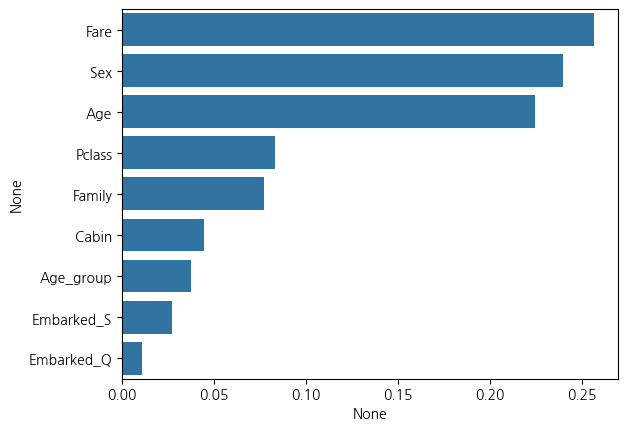

In [183]:
# 특성 중요도 시각화
importances_values = best_model.feature_importances_
importances = pd.Series(importances_values, index = X_train.columns)
top = importances.sort_values(ascending=False)

sns.barplot(x=top, y=top.index)
plt.show()
